# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report,roc_curve,auc, recall_score
from sklearn.ensemble import RandomForestClassifier

import time


%matplotlib inline


# Load the datasets

In [2]:
data_fraud = pd.read_csv('./raw_data/Fraud_Data.csv' , parse_dates= ['signup_time' , 'purchase_time'])
data_ip = pd.read_csv('./raw_data/IpAddress_to_Country.csv')

# Data inspection

In [3]:
data_fraud.head()

,"""user_id""",signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
data_fraud.rename(columns = {' "user_id"' : 'user_id'} , inplace = True)

In [5]:
data_fraud.dtypes

user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object

In [6]:
data_fraud.duplicated().sum()

0

In [7]:
data_fraud['user_id'].duplicated().sum()

0

In [8]:
data_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB


In [9]:
data_fraud.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [10]:
data_ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [11]:
data_ip.duplicated().sum()

0

In [12]:
data_ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


# Date transformation

In [13]:
data_fraud['signup_year'] = data_fraud['signup_time'].dt.year
data_fraud['signup_month'] = data_fraud['signup_time'].dt.month
data_fraud['signup_date'] = data_fraud['signup_time'].dt.day
data_fraud['signup_time_hour'] = data_fraud['signup_time'].dt.hour
data_fraud['signup_time_hour_sin'] = np.sin(2 * np.pi * data_fraud['signup_time'].dt.hour/24.0)
data_fraud['signup_time_hour_cos'] = np.cos(2 * np.pi * data_fraud['signup_time'].dt.hour/24.0)



In [14]:
data_fraud['purchase_year'] = data_fraud['purchase_time'].dt.year
data_fraud['purchase_month'] = data_fraud['purchase_time'].dt.month
data_fraud['purchase_date'] = data_fraud['purchase_time'].dt.day
data_fraud['purchase_time_hour'] = data_fraud['purchase_time'].dt.hour
data_fraud['purchase_time_hour_sin'] = np.sin(2 * np.pi * data_fraud['purchase_time'].dt.hour/24.0)
data_fraud['purchase_time_hour_cos'] = np.cos(2 * np.pi * data_fraud['purchase_time'].dt.hour/24.0)


In [15]:
data_fraud['signup_year'].value_counts()
data_fraud['purchase_year'].value_counts()

2015    151112
Name: purchase_year, dtype: int64

In [16]:
data_fraud.drop(columns= ['signup_year' , 'purchase_year'] , inplace = True)

# Add country into fraud dataset

In [17]:
data_ip

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.677722e+07,16777471,Australia
1,1.677747e+07,16777727,China
2,1.677773e+07,16778239,China
3,1.677824e+07,16779263,Australia
4,1.677926e+07,16781311,China
...,...,...,...
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore


In [18]:
ip_list = data_fraud['ip_address'].tolist()
countries = []
for i in ip_list:
    temp_country = data_ip[(data_ip['lower_bound_ip_address'] <= i) & (data_ip['upper_bound_ip_address'] >= i)]['country']
    if len(temp_country) == 0:
        countries.append('NA')
    else:
        countries.append(temp_country.iloc[0])
        


In [19]:
len(countries)

151112

In [20]:
data_fraud['country'] = countries

In [21]:
data_fraud['country'].value_counts(normalize = True)

United States     0.384146
NA                0.145362
China             0.079663
Japan             0.048348
United Kingdom    0.029713
                    ...   
Myanmar           0.000007
Vanuatu           0.000007
Dominica          0.000007
Niger             0.000007
Guadeloupe        0.000007
Name: country, Length: 182, dtype: float64

# Data visualization

In [22]:
data_fraud.dtypes

user_id                            int64
signup_time               datetime64[ns]
purchase_time             datetime64[ns]
purchase_value                     int64
device_id                         object
source                            object
browser                           object
sex                               object
age                                int64
ip_address                       float64
class                              int64
signup_month                       int64
signup_date                        int64
signup_time_hour                   int64
signup_time_hour_sin             float64
signup_time_hour_cos             float64
purchase_month                     int64
purchase_date                      int64
purchase_time_hour                 int64
purchase_time_hour_sin           float64
purchase_time_hour_cos           float64
country                           object
dtype: object

Text(0.5, 1.0, 'Distribution of Source')

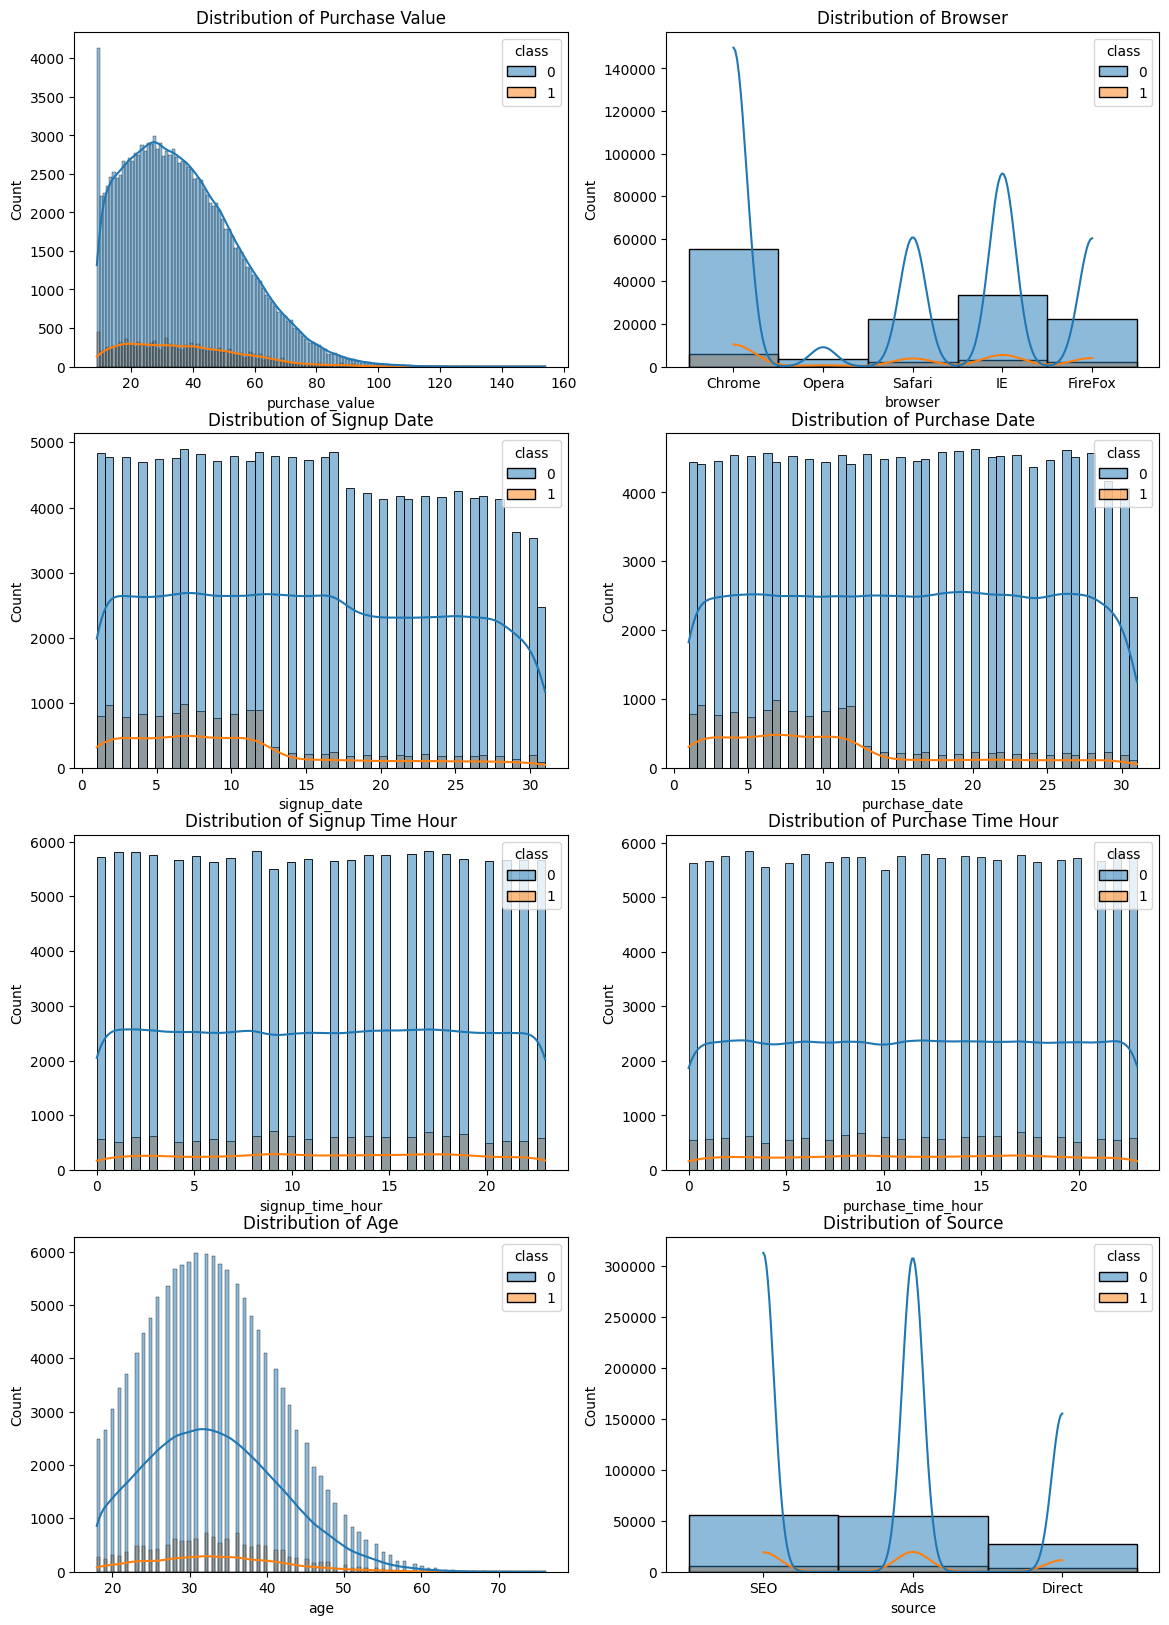

In [23]:
fig, axes = plt.subplots(4, 2, figsize=(14, 20))

sns.histplot(data = data_fraud , x = 'purchase_value' , hue = 'class', kde = True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Purchase Value')

sns.histplot(data = data_fraud , x = 'browser' , hue = 'class', kde = True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Browser')

sns.histplot(data = data_fraud , x = 'signup_date' , hue = 'class', kde = True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Signup Date')

sns.histplot(data = data_fraud , x = 'purchase_date' , hue = 'class', kde = True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Purchase Date')

sns.histplot(data = data_fraud , x = 'signup_time_hour' , hue = 'class', kde = True, ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Signup Time Hour')

sns.histplot(data = data_fraud , x = 'purchase_time_hour' , hue = 'class', kde = True, ax=axes[2, 1])
axes[2, 1].set_title('Distribution of Purchase Time Hour')

sns.histplot(data = data_fraud , x = 'age' , hue = 'class', kde = True, ax=axes[3, 0])
axes[3, 0].set_title('Distribution of Age')

sns.histplot(data = data_fraud , x = 'source' , hue = 'class', kde = True, ax=axes[3, 1])
axes[3, 1].set_title('Distribution of Source')

## Based on the visualization above, most of the features against the class seem normally distributed. Only the sign up and purchase date seem to be focused on the first half of the month for those "fraud" labelling cases.

# Analyzing the fraud dataset

In [24]:
analyze_fraud = data_fraud[(data_fraud['class'] == 1)]

In [25]:
analyze_fraud['country'].value_counts()/len(analyze_fraud)

United States     0.392269
NA                0.133065
China             0.073705
Japan             0.050526
United Kingdom    0.033708
                    ...   
Malawi            0.000071
Serbia            0.000071
Turkmenistan      0.000071
Macedonia         0.000071
Mauritius         0.000071
Name: country, Length: 110, dtype: float64

## For the fraud transaction, among the top 3 countries, 39% came from US, 13% come from undetected IP address while 7% come from China. 

In [26]:
analyze_fraud['device_id'].value_counts()

EQYVNEGOFLAWK    19
NGQCKIADMZORL    19
ZUSVMDEZRBDTX    19
ITUMJCKWEYNDD    19
CQTUVBYIWWWBC    19
                 ..
FFUZFWQSFWAIS     1
UDQYUJIWDHSKN     1
TQEPQVWPEKVZG     1
NBZLSOYRVCUAE     1
XPSKTWGPWINLR     1
Name: device_id, Length: 6987, dtype: int64

## There is some cases come from same device for 19 fraud transactions.

In [27]:
analyze_fraud[analyze_fraud['device_id'] == 'NGQCKIADMZORL']

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,signup_date,signup_time_hour,signup_time_hour_sin,signup_time_hour_cos,purchase_month,purchase_date,purchase_time_hour,purchase_time_hour_sin,purchase_time_hour_cos,country
13973,278428,2015-01-03 13:10:40,2015-01-03 13:10:41,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,...,3,13,-0.258819,-0.965926,1,3,13,-0.258819,-0.965926,New Zealand
17397,53591,2015-01-03 13:10:43,2015-01-03 13:10:44,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,...,3,13,-0.258819,-0.965926,1,3,13,-0.258819,-0.965926,New Zealand
17551,384595,2015-01-03 13:10:35,2015-01-03 13:10:36,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,...,3,13,-0.258819,-0.965926,1,3,13,-0.258819,-0.965926,New Zealand
19324,181018,2015-01-03 13:10:41,2015-01-03 13:10:42,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,...,3,13,-0.258819,-0.965926,1,3,13,-0.258819,-0.965926,New Zealand
23254,226646,2015-01-03 13:10:51,2015-01-03 13:10:52,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,...,3,13,-0.258819,-0.965926,1,3,13,-0.258819,-0.965926,New Zealand
23670,381483,2015-01-03 13:10:49,2015-01-03 13:10:50,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,...,3,13,-0.258819,-0.965926,1,3,13,-0.258819,-0.965926,New Zealand
27888,277313,2015-01-03 13:10:45,2015-01-03 13:10:46,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,...,3,13,-0.258819,-0.965926,1,3,13,-0.258819,-0.965926,New Zealand
62937,186785,2015-01-03 13:10:52,2015-01-03 13:10:53,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,...,3,13,-0.258819,-0.965926,1,3,13,-0.258819,-0.965926,New Zealand
64799,38749,2015-01-03 13:10:44,2015-01-03 13:10:45,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,...,3,13,-0.258819,-0.965926,1,3,13,-0.258819,-0.965926,New Zealand
68063,179901,2015-01-03 13:10:50,2015-01-03 13:10:51,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,...,3,13,-0.258819,-0.965926,1,3,13,-0.258819,-0.965926,New Zealand


## It seem like there is a rule based mechanism by some organization. Look like a programatic method, signup time and purchase time almost happen simultaneously. The time different is like only 1 second different for signup and purchase time. Happening at the same day. But this need to be verified with other device which has repeated fraud transaction. 

# Try to analyse the top categories of country for those device that repeatly do false transaction for more than 10 times

In [28]:
temp_df = analyze_fraud.groupby(['device_id','country'], as_index = False).size()
temp_df.head()

,device_id,country,size
0,AAAXXOZJRZRAO,United Kingdom,10
1,AADGMPYOPXXCX,Spain,1
2,AAEWGRKQJJMVI,United States,1
3,AAIEIZJZIKDLN,Slovakia (SLOVAK Republic),1
4,AAJCSUCPHKORJ,United States,1


In [29]:
temp_df[temp_df['size'] >= 10]['country'].value_counts(normalize = True)

United States                      0.400000
NA                                 0.119048
China                              0.059524
Japan                              0.054762
United Kingdom                     0.038095
Canada                             0.028571
Brazil                             0.026190
Korea Republic of                  0.026190
France                             0.023810
India                              0.019048
Germany                            0.016667
Mexico                             0.014286
Sweden                             0.011905
Australia                          0.009524
Denmark                            0.009524
Norway                             0.009524
New Zealand                        0.007143
Chile                              0.007143
Italy                              0.007143
Ireland                            0.007143
Indonesia                          0.007143
Spain                              0.004762
Taiwan; Republic of China (ROC) 

## For those device being repeatly detected as fraud transaction, among the top three group are remain unchanged, 40% came from US, 12% come from undetected IP address while 6% come from China. 

# Feature engineering

### Include time different between signup time and purchase time

In [30]:
data_fraud['time_different_minutes'] = ((data_fraud['purchase_time'] - data_fraud['signup_time']).dt.total_seconds())/60


In [31]:
data_fraud.drop(columns = ['signup_time' , 'purchase_time'] , inplace = True)

In [32]:
data_fraud.head()

,user_id,purchase_value,device_id,source,browser,sex,age,ip_address,class,signup_month,...,signup_time_hour,signup_time_hour_sin,signup_time_hour_cos,purchase_month,purchase_date,purchase_time_hour,purchase_time_hour_sin,purchase_time_hour_cos,country,time_different_minutes
0,22058,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,2,...,22,-0.500000,8.660254e-01,4,18,2,0.500000,8.660254e-01,Japan,75111.366667
1,333320,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,6,...,20,-0.866025,5.000000e-01,6,8,1,0.258819,9.659258e-01,United States,299.066667
2,1359,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,1,...,18,-1.000000,-1.836970e-16,1,1,18,-1.000000,-1.836970e-16,United States,0.016667
3,150084,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,4,...,21,-0.707107,7.071068e-01,5,4,13,-0.258819,-9.659258e-01,NA,8201.416667
4,221365,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,7,...,7,0.965926,-2.588190e-01,9,9,18,-1.000000,-1.836970e-16,United States,72691.016667


# Machine learning 

In [33]:
df = data_fraud

## Class imbalance

In [34]:
df['class'].value_counts(normalize= True)

0    0.906354
1    0.093646
Name: class, dtype: float64

## Remove useless features from training as fraud transaction should not have much relation ship with user id and device id

In [35]:
X = df.drop(columns = ['class', 'user_id' , 'device_id'])
y = df['class']

In [36]:
X_train , X_test , y_train , y_test = train_test_split(X , y , stratify = y , test_size = 0.2 , random_state = 42)


## Apply oversampling technique to balance the class

In [37]:
oversample = RandomOverSampler(random_state = 42)
X_resample , y_resample = oversample.fit_resample(X_train , y_train)

## Creating training features

In [38]:
X_resample.select_dtypes(include=['int' , 'float']).columns

Index(['purchase_value', 'age', 'ip_address', 'signup_month', 'signup_date',
       'signup_time_hour', 'signup_time_hour_sin', 'signup_time_hour_cos',
       'purchase_month', 'purchase_date', 'purchase_time_hour',
       'purchase_time_hour_sin', 'purchase_time_hour_cos',
       'time_different_minutes'],
      dtype='object')

In [39]:
cat_features = ['source', 'browser', 'sex', 'country']
num_features = ['purchase_value', 'age', 'ip_address', 'signup_time_hour_sin', 'signup_time_hour_cos',
       'purchase_time_hour_sin', 'purchase_time_hour_cos',
       'time_different_minutes']


## Make processing pipeline

In [40]:
num_transformer = make_pipeline(StandardScaler())
cat_transformer = make_pipeline(OneHotEncoder(drop = "if_binary" , handle_unknown = 'ignore'))

In [41]:
processor = make_column_transformer((num_transformer , num_features) , (cat_transformer , cat_features) , verbose_feature_names_out = True)
processor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['purchase_value', 'age', 'ip_address',
                                  'signup_time_hour_sin',
                                  'signup_time_hour_cos',
                                  'purchase_time_hour_sin',
                                  'purchase_time_hour_cos',
                                  'time_different_minutes']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['source', 'browser', 'sex', 'country'])])

In [42]:
X_train_processed = processor.fit_transform(X_resample)
X_test_processed = processor.transform(X_test)


/home/jwshee/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Experiment 1 Random Forest

In [43]:
model_rf = RandomForestClassifier(n_estimators = 100 , oob_score = True , n_jobs = -1)
start = time.time()
model_rf.fit(X_train_processed , y_resample)
end = time.time()
training_time = end - start

/tmp/ipykernel_9995/894312504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append(new_row , ignore_index = True).sort_values('Importance' , ascending = True)


<BarContainer object of 18 artists>

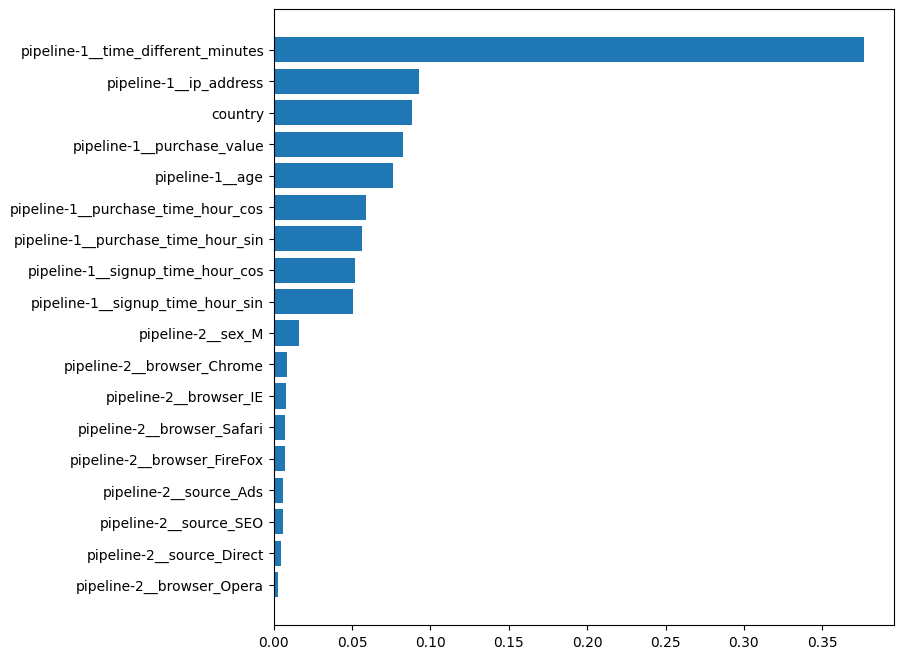

In [44]:
feature_df = pd.DataFrame({'Feature': processor.get_feature_names_out(), 'Importance': model_rf.feature_importances_}).sort_values('Importance' , ascending = False)
country_rows = feature_df[feature_df['Feature'].str.startswith('pipeline-2__country_')]
overall_country_importance = country_rows['Importance'].sum()
new_row = {'Feature': 'country' , 'Importance' : overall_country_importance}
feature_df = feature_df[~feature_df['Feature'].str.startswith('pipeline-2__country_')]
feature_df = feature_df.append(new_row , ignore_index = True).sort_values('Importance' , ascending = True)
plt.figure(figsize=(8,8))
plt.barh(feature_df['Feature'] , feature_df['Importance'] )




In [45]:
start = time.time()
y_rf_predict = model_rf.predict(X_test_processed)
end = time.time()
prediction_time = end - start
y_test = np.array(y_test)
print(classification_report(y_test, y_rf_predict))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223



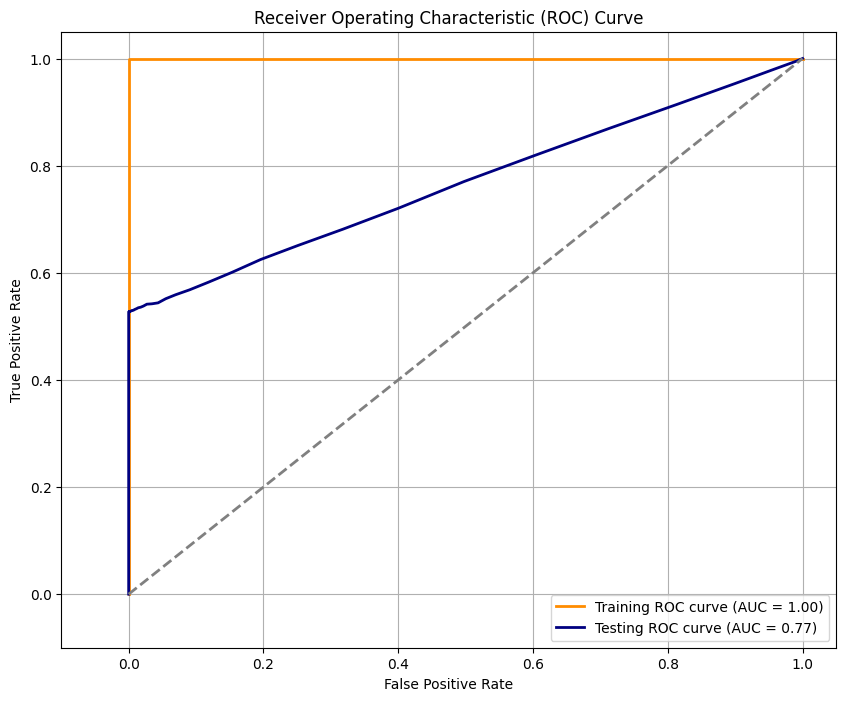

In [46]:
y_rf_predict_proba = model_rf.predict_proba(X_test_processed)[:,1]
y_train_probs = model_rf.predict_proba(X_train_processed)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_resample, y_train_probs)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_rf_predict_proba)
roc_auc_test = auc(fpr_test, tpr_test)
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Training ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label=f'Testing ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([- 0.1, 1.05])
plt.ylim([- 0.1, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [47]:
recall_rf = recall_score(y_test , y_rf_predict)
result = {"Experiment" : ["experiment 1"] , "Recall" : [recall_rf] , "AUC" : [roc_auc_test] , 'Training time' : [training_time] , 'Prediction time' : [prediction_time]
          , 'Number of features' : [model_rf.n_features_in_]}
result

{'Experiment': ['experiment 1'],
 'Recall': [0.5268551236749116],
 'AUC': [0.7670267377637294],
 'Training time': [18.280123233795166],
 'Prediction time': [0.1057884693145752],
 'Number of features': [197]}

## Experiment 1, recall 53% ,  AUC 76%

## Experiment 2 Random Forest , remove not importance features eg. sources , browser ,  signup and purchase time

/home/jwshee/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/tmp/ipykernel_9995/3208689336.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append(new_row , ignore_index = True).sort_values('Importance' , ascending = True)


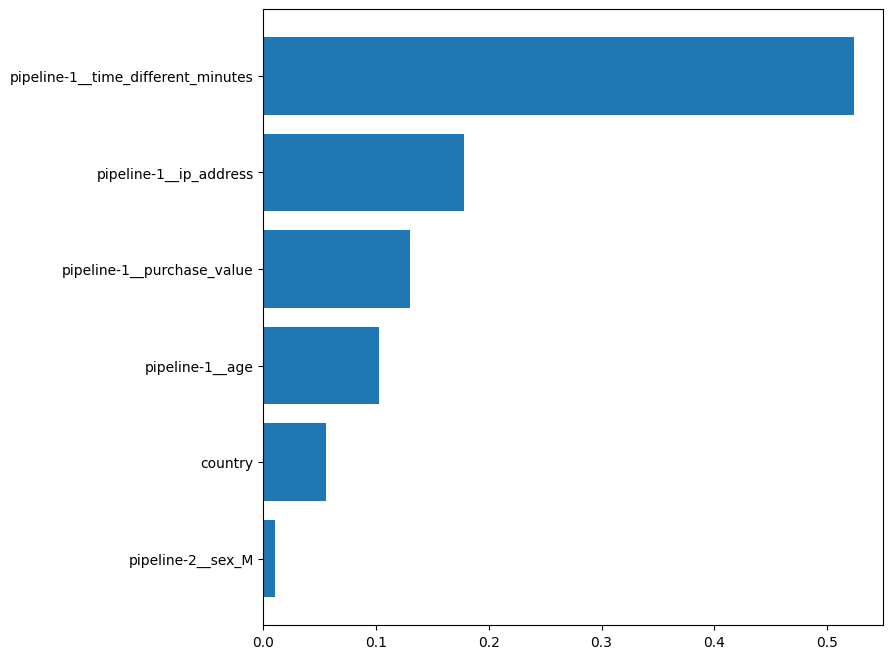

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.96      0.53      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.96      0.76      0.83     30223
weighted avg       0.95      0.95      0.95     30223



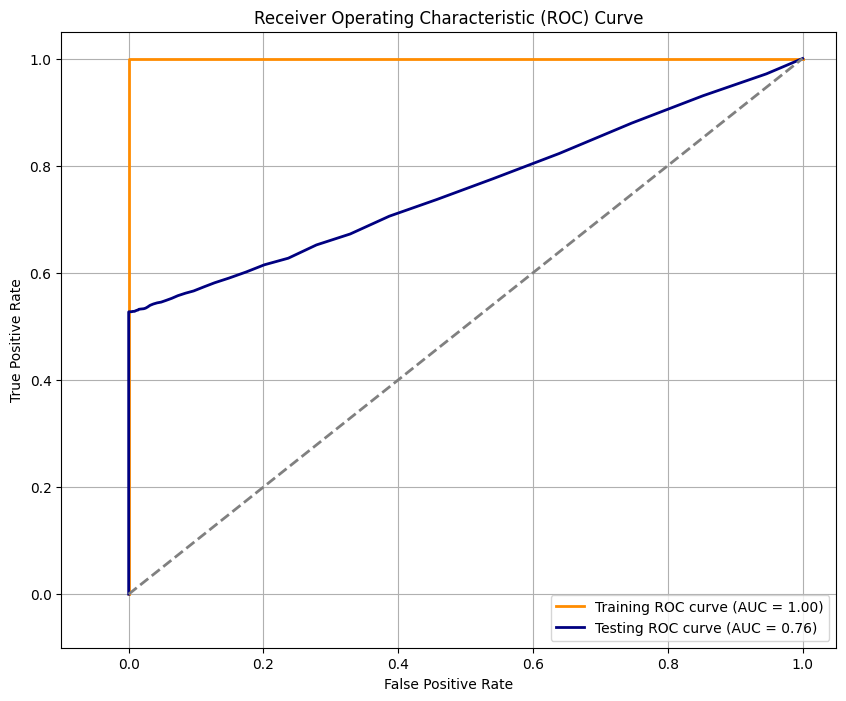

In [48]:
cat_features = ['sex', 'country']
num_features = ['purchase_value', 'age', 'ip_address', 'time_different_minutes']
num_transformer = make_pipeline(StandardScaler())
cat_transformer = make_pipeline(OneHotEncoder(drop = "if_binary" , handle_unknown = 'ignore'))
processor = make_column_transformer((num_transformer , num_features) , (cat_transformer , cat_features) , verbose_feature_names_out = True)
X_train_processed = processor.fit_transform(X_resample)
X_test_processed = processor.transform(X_test)
model_rf = RandomForestClassifier(n_estimators = 100 , oob_score = True , n_jobs = -1)
start = time.time()
model_rf.fit(X_train_processed , y_resample)
end = time.time()
training_time = end - start
feature_df = pd.DataFrame({'Feature': processor.get_feature_names_out(), 'Importance': model_rf.feature_importances_}).sort_values('Importance' , ascending = False)
country_rows = feature_df[feature_df['Feature'].str.startswith('pipeline-2__country_')]
overall_country_importance = country_rows['Importance'].sum()
new_row = {'Feature': 'country' , 'Importance' : overall_country_importance}
feature_df = feature_df[~feature_df['Feature'].str.startswith('pipeline-2__country_')]
feature_df = feature_df.append(new_row , ignore_index = True).sort_values('Importance' , ascending = True)
plt.figure(figsize=(8,8))
plt.barh(feature_df['Feature'] , feature_df['Importance'] )
plt.show()
start = time.time()
y_rf_predict = model_rf.predict(X_test_processed)
end = time.time()
prediction_time = end - start
y_test = np.array(y_test)
print(classification_report(y_test, y_rf_predict))
y_rf_predict_proba = model_rf.predict_proba(X_test_processed)[:,1]
y_train_probs = model_rf.predict_proba(X_train_processed)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_resample, y_train_probs)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_rf_predict_proba)
roc_auc_test = auc(fpr_test, tpr_test)
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Training ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label=f'Testing ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([- 0.1, 1.05])
plt.ylim([- 0.1, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
recall_rf = recall_score(y_test , y_rf_predict)
result["Experiment"].append("experiment 2")
result["Recall"].append(recall_rf)
result["AUC"].append(roc_auc_test)
result['Training time'].append(training_time)
result['Prediction time'].append(prediction_time)
result['Number of features'].append(model_rf.n_features_in_)

## Experiment 2, recall 53% ,  AUC 76%

## Experiment 3: Tuning Random Forest based on model in experiment 2

In [49]:
cat_features = ['sex', 'country']
num_features = ['purchase_value', 'age', 'ip_address', 'time_different_minutes']
num_transformer = make_pipeline(StandardScaler())
cat_transformer = make_pipeline(OneHotEncoder(drop = "if_binary" , handle_unknown = 'ignore'))
processor = make_column_transformer((num_transformer , num_features) , (cat_transformer , cat_features) , verbose_feature_names_out = True)
X_train_processed = processor.fit_transform(X_resample)
X_test_processed = processor.transform(X_test)
model_rf = RandomForestClassifier(n_jobs = -1)

/home/jwshee/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
param_grid = {
    'n_estimators': np.arange(10,100,5),
    'max_depth': np.arange(10,100,5),
    'min_samples_split': np.arange(2,10,2),
    'min_samples_leaf': np.arange(1,5,1)
}

search = RandomizedSearchCV(estimator = model_rf , param_distributions = param_grid , n_iter = 50 ,  cv = 5 , scoring = 'recall')
search.fit(X_train_processed , y_resample)

In [50]:
results_df = pd.DataFrame(search.cv_results_).sort_values('mean_test_score' , ascending = False)
best_rf = search.best_estimator_
best_rf = RandomForestClassifier(max_depth=85, n_estimators=30, n_jobs=-1)

/tmp/ipykernel_9995/2938806274.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append(new_row , ignore_index = True).sort_values('Importance' , ascending = True)


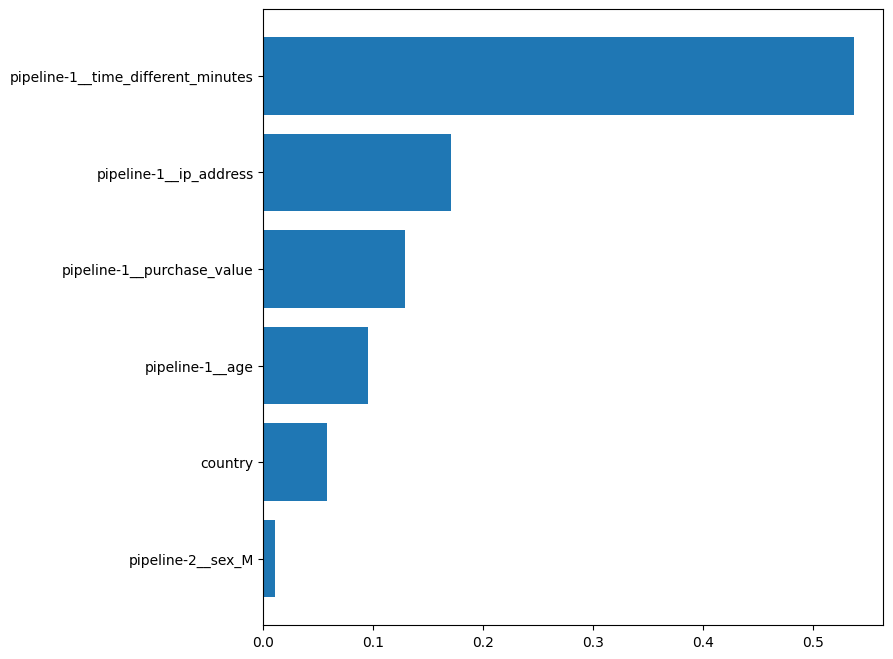

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     27393
           1       0.96      0.53      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.96      0.76      0.83     30223
weighted avg       0.95      0.95      0.95     30223



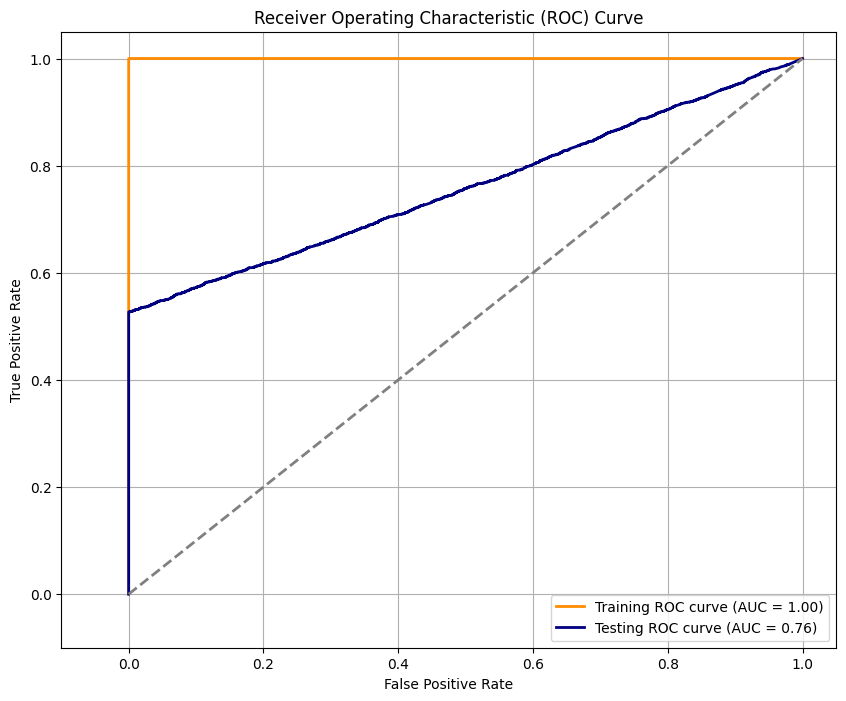

In [51]:
start = time.time()
best_rf.fit(X_train_processed , y_resample)
end = time.time()
training_time = end - start
feature_df = pd.DataFrame({'Feature': processor.get_feature_names_out(), 'Importance': best_rf.feature_importances_}).sort_values('Importance' , ascending = False)
country_rows = feature_df[feature_df['Feature'].str.startswith('pipeline-2__country_')]
overall_country_importance = country_rows['Importance'].sum()
new_row = {'Feature': 'country' , 'Importance' : overall_country_importance}
feature_df = feature_df[~feature_df['Feature'].str.startswith('pipeline-2__country_')]
feature_df = feature_df.append(new_row , ignore_index = True).sort_values('Importance' , ascending = True)
plt.figure(figsize=(8,8))
plt.barh(feature_df['Feature'] , feature_df['Importance'] )
plt.show()
start = time.time()
y_rf_predict = best_rf.predict(X_test_processed)
end = time.time()
prediction_time = end - start
y_test = np.array(y_test)
print(classification_report(y_test, y_rf_predict))
y_rf_predict_proba = best_rf.predict_proba(X_test_processed)[:,1]
y_train_probs = best_rf.predict_proba(X_train_processed)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_resample, y_train_probs)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_rf_predict_proba)
roc_auc_test = auc(fpr_test, tpr_test)
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Training ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label=f'Testing ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([- 0.1, 1.05])
plt.ylim([- 0.1, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
recall_rf = recall_score(y_test , y_rf_predict)
result["Experiment"].append("experiment 3")
result["Recall"].append(recall_rf)
result["AUC"].append(roc_auc_test)
result['Training time'].append(training_time)
result['Prediction time'].append(prediction_time)
result['Number of features'].append(best_rf.n_features_in_)

In [52]:
pd.DataFrame(result)

,Experiment,Recall,AUC,Training time,Prediction time,Number of features
0,experiment 1,0.526855,0.767027,18.280123,0.105788,197
1,experiment 2,0.527208,0.758554,14.914171,0.125194,185
2,experiment 3,0.527208,0.758976,3.907157,0.040319,185


## In experiment 3, the result recall and AUC is similar but training and prediction time is reduced significantly.

# As conclusion, based on three experiements, the recall and AUC are similar. However, the model in experiment 3 has a reduced number of features and also significant reduction in both training and prediction time as compared to model in experiment 1 and 2. Therefore model 3 is the best among three models. If we would like to increase the true positive rate, we may need to explore to adjust the threshold but this will come with a consequences that the false positive rate also will increase linearly. We can also explore for other algorithims to verify their performance. 